In [1]:
import pandas as pd
import numpy as np  
from tqdm import tqdm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 
import glob
import re
import pyhrv.time_domain as td

ann_db = pd.read_csv("database/ann_db.csv")
ann_db.rename(columns={'Unnamed: 0':'Labels'}, inplace=True)
ann_db = ann_db.set_index('Labels')
ann_db.index

def init_dataframe():
    path = "database/signals"
    files = glob.glob(path + "/*.csv")

    data_frame = pd.DataFrame()

    for filename in files:
        name = re.sub("[^0-9]", "", filename)
        df = pd.read_csv(filename, index_col=None)
        data_frame = data_frame.append(
            {
                'tag': name,
                'Fhr': list(df['FHR']), 
                'UC': df['UC'],
                'Apgar1': ann_db[name]['Apgar1'],
                'Apgar5': ann_db[name]['Apgar5'],
                'labels': ann_db[name], 
                'pH': ann_db[name]['pH']
            },
            ignore_index=True
        )
    return data_frame

df = init_dataframe()

In [2]:
'''
* init in dataframe a separate column that indicates the healthy state according to Apgar 1
* healthy_thresh >= 7
'''
healthy_thresh = 7
for i, signal in df.iterrows():
    df.at[i,'Healthy Birth (1)'] = 1 if(df.iloc[i]['Apgar1'] >= healthy_thresh) else 0


# keep in a dataframe named 'df1h' only those whose Apgar1 are greater than 7 (healthy state)
df1h = df[df['Healthy Birth (1)'] == 1].reset_index().drop('index', axis=1)
# keep in a dataframe named 'df1u' only those whose Apgar1 are less than 7 (unhealthy state)
df1u = df[df['Healthy Birth (1)'] == 0].reset_index().drop('index', axis=1)


'''
* init in dataframe a separate column that indicates the healthy state according to Apgar 1
* healthy_thresh >= 7
'''
healthy_thresh = 7
for i, signal in df.iterrows():
    df.at[i,'Healthy Birth (2)'] = 1 if(df.iloc[i]['Apgar5'] >= healthy_thresh) else 0


# keep in a dataframe named 'df1h' only those whose Apgar5 are greater than 7 (healthy state)
df5h = df[df['Healthy Birth (2)'] == 1].reset_index().drop(['index','Healthy Birth (2)'], axis=1)
# keep in a dataframe named 'df1u' only those whose Apgar5 are less than 7 (unhealthy state)
df5u = df[df['Healthy Birth (2)'] == 0].reset_index().drop(['index','Healthy Birth (2)'], axis=1)

df1h.shape, df1u.shape, df5h.shape, df5u.shape
df1h.head()


,tag,Fhr,UC,Apgar1,Apgar5,labels,pH,Healthy Birth (1)
0,1002,"[146.25, 146.25, 150.25, 148.5, 148.5, 143.5, ...",0 26.0 1 26.0 2 25.5 3 ...,8.0,8.0,Labels pH 7.00 BDecf ...,7.00,1.0
1,1003,"[137.5, 137.5, 137.5, 139.5, 139.5, 140.75, 14...",0 0.0 1 0.0 2 0.0 3 ...,7.0,9.0,Labels pH 7.20 BDecf ...,7.20,1.0
2,1004,"[153.75, 153.75, 153.75, 154.75, 154.75, 153.7...",0 46.0 1 43.0 2 43.0 3 ...,8.0,9.0,Labels pH 7.30 BDecf ...,7.30,1.0
3,1005,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0 0.0 1 0.0 2 0.0 3 ...,9.0,10.0,Labels pH 7.30 BDecf ...,7.30,1.0
4,1006,"[143.5, 142.75, 142.75, 142.75, 142.75, 141.5,...",0 0.0 1 0.0 2 0.0 3 ...,8.0,9.0,Labels pH 7.23 BDecf ...,7.23,1.0


In [12]:
df5h.head()

,tag,Fhr,UC,Apgar1,Apgar5,labels,pH,Healthy Birth (1)
0,1001,"[150.5, 150.5, 151.0, 151.25, 151.25, 150.25, ...",0 7.0 1 8.5 2 8.5 3 ...,6.0,8.0,Labels pH 7.14 BDecf ...,7.14,0.0
1,1002,"[146.25, 146.25, 150.25, 148.5, 148.5, 143.5, ...",0 26.0 1 26.0 2 25.5 3 ...,8.0,8.0,Labels pH 7.00 BDecf ...,7.00,1.0
2,1003,"[137.5, 137.5, 137.5, 139.5, 139.5, 140.75, 14...",0 0.0 1 0.0 2 0.0 3 ...,7.0,9.0,Labels pH 7.20 BDecf ...,7.20,1.0
3,1004,"[153.75, 153.75, 153.75, 154.75, 154.75, 153.7...",0 46.0 1 43.0 2 43.0 3 ...,8.0,9.0,Labels pH 7.30 BDecf ...,7.30,1.0
4,1005,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0 0.0 1 0.0 2 0.0 3 ...,9.0,10.0,Labels pH 7.30 BDecf ...,7.30,1.0


In [4]:
def drop_restictions(df, name):
    records_to_drop = list()
    cc = ca = cd = cw = 0
    
    for i in range(df.shape[0]):
        if (df.iloc[i]['labels']['Deliv. type'] != 1.0):
            records_to_drop.append(i); cc+=1

        if (df.iloc[i]['labels']['Age'] < 18):
            records_to_drop.append(i); ca+=1

        if (df.iloc[i]['labels']['Hypertension'] == 1 or
            df.iloc[i]['labels']['Preeclampsia'] == 1 or 
            df.iloc[i]['labels']['Diabetes'] == 1):
            records_to_drop.append(i); cd+=1

        if (df.iloc[i]['labels']['Gest. weeks'] < 37.5):
            records_to_drop.append(i); cw+=1
    
    print('--',name,'--')
    print(cw,' underweeked records dropped')
    print(cd,' diseased records dropped')
    print(ca,' underage records dropped')
    print(cc,' casarean records dropped')
    
    print(len(records_to_drop), 'total records dropped')
    return df.drop(records_to_drop).reset_index().drop('index', axis=1)

df1h_r = drop_restictions(df1h,'df1h')
df1u_r = drop_restictions(df1u,'df1u')
df5h_r = drop_restictions(df5h,'df5h')
df5u_r = drop_restictions(df5u,'df5u')
df1h_r.head()

-- df1h --
13  underweeked records dropped
74  diseased records dropped
0  underage records dropped
35  casarean records dropped
122 total records dropped
-- df1u --
5  underweeked records dropped
12  diseased records dropped
0  underage records dropped
11  casarean records dropped
28 total records dropped
-- df5h --
18  underweeked records dropped
82  diseased records dropped
0  underage records dropped
43  casarean records dropped
143 total records dropped
-- df5u --
0  underweeked records dropped
4  diseased records dropped
0  underage records dropped
3  casarean records dropped
7 total records dropped


,tag,Fhr,UC,Apgar1,Apgar5,labels,pH,Healthy Birth (1)
0,1002,"[146.25, 146.25, 150.25, 148.5, 148.5, 143.5, ...",0 26.0 1 26.0 2 25.5 3 ...,8.0,8.0,Labels pH 7.00 BDecf ...,7.00,1.0
1,1003,"[137.5, 137.5, 137.5, 139.5, 139.5, 140.75, 14...",0 0.0 1 0.0 2 0.0 3 ...,7.0,9.0,Labels pH 7.20 BDecf ...,7.20,1.0
2,1004,"[153.75, 153.75, 153.75, 154.75, 154.75, 153.7...",0 46.0 1 43.0 2 43.0 3 ...,8.0,9.0,Labels pH 7.30 BDecf ...,7.30,1.0
3,1005,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0 0.0 1 0.0 2 0.0 3 ...,9.0,10.0,Labels pH 7.30 BDecf ...,7.30,1.0
4,1006,"[143.5, 142.75, 142.75, 142.75, 142.75, 141.5,...",0 0.0 1 0.0 2 0.0 3 ...,8.0,9.0,Labels pH 7.23 BDecf ...,7.23,1.0


In [5]:
SEGMENT_SIZE = 25 # megalo SEGMENT_SIZE -> ligotero strict
NOISY_THRESH = 0.20 # mikro NOISY_THRESH -> eimaste  strict
NOISE_RETRV_THRESH = 0.25 # mikro NOISE_RETRV_THRESH -> poly smoothing
N_PREV_VALS = 10

In [6]:
def drop_noisy_records(df, thresh=0.2):
    noisy_records = list()
    
    for i in range(df.shape[0]):
        record = df.iloc[i]
        perc_zeros = record['Fhr'].count(0) / len(record['Fhr'])
        if( perc_zeros > thresh ):
            noisy_records.append(i)    
    return  df.drop(noisy_records).reset_index().drop('index', axis=1)


In [7]:
df1h_r_n = drop_noisy_records(df1h_r,thresh=NOISY_THRESH)
df1u_r_n = drop_noisy_records(df1u_r,thresh=NOISY_THRESH)
df5h_r_n = drop_noisy_records(df5h_r,thresh=NOISY_THRESH)
df5u_r_n = drop_noisy_records(df5u_r,thresh=NOISY_THRESH)

df1h_r_n.shape, df1u_r_n.shape, df5h_r_n.shape, df5u_r_n.shape

((207, 8), (27, 8), (227, 8), (7, 8))

In [ ]:
'''
* a fhr pca vector to another column
* need to cut all signals to have all the shame shape
'''

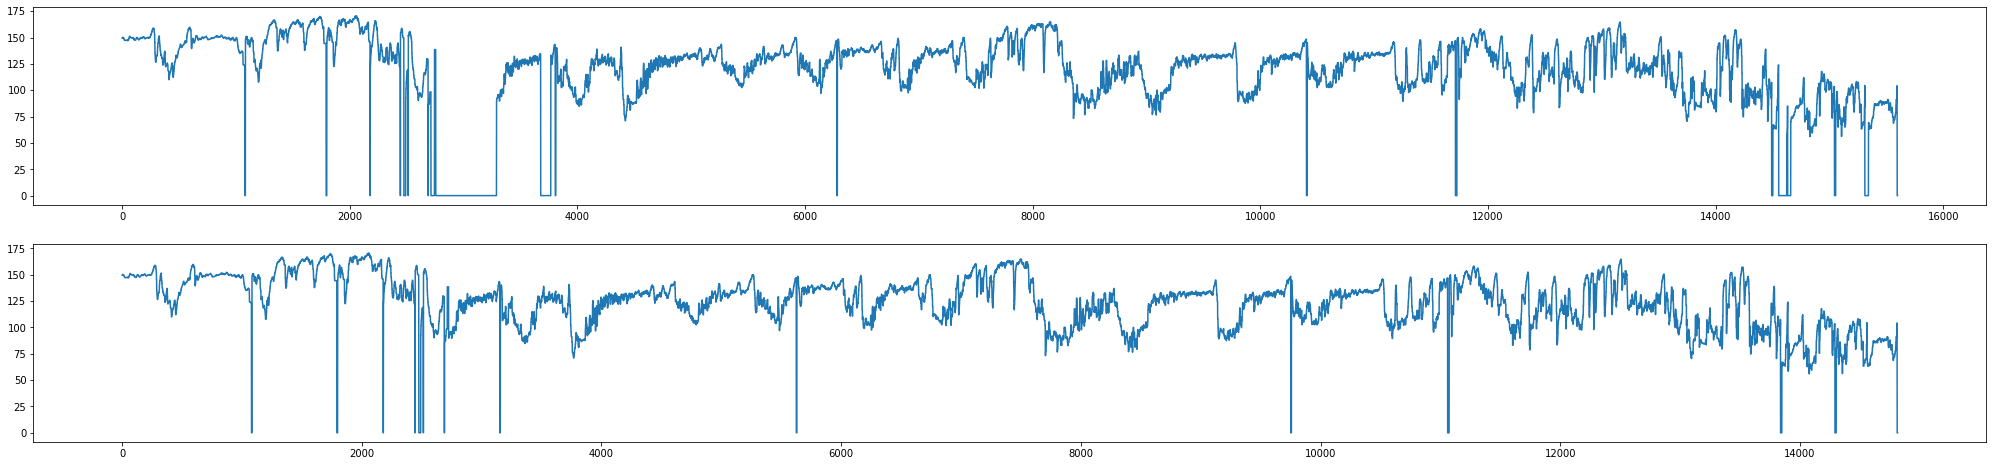

In [9]:
def drop_zero_segments(df_input, segment_size = 20):
    df = df_input.copy()
    
    for row_i , fhr in df_input['Fhr'].iteritems():
        fhr_list = list(fhr) # get fhr of record row_i as list
        fhr_list_out = list() # set an empty list
        count = 0
        for j, value in enumerate(fhr_list):     
            if(value == 0):
                count += 1                
            else:
                if(count >= segment_size):
                    fhr_list_out = fhr_list_out[:-count]
                count = 0    
            fhr_list_out.append(value)
        df.at[row_i, 'Fhr'] = fhr_list_out
        
    return df

df1h_r_n_zs = drop_zero_segments(df1h_r_n, segment_size=SEGMENT_SIZE)
df1u_r_n_zs = drop_zero_segments(df1u_r_n, segment_size=SEGMENT_SIZE)
df5h_r_n_zs = drop_zero_segments(df5h_r_n, segment_size=SEGMENT_SIZE)
df5u_r_n_zs = drop_zero_segments(df5u_r_n, segment_size=SEGMENT_SIZE)


df1h_r_n_zs = df1h_r_n_zs.set_index('tag')
df1u_r_n_zs = df1u_r_n_zs.set_index('tag')
df5h_r_n_zs = df5h_r_n_zs.set_index('tag')
df5u_r_n_zs = df5u_r_n_zs.set_index('tag')

fig,ax = plt.subplots(2,1, figsize=(35,8))
ax[0].plot(df1h_r_n.iloc[3]['Fhr'])
ax[1].plot(df1h_r_n_zs.loc['1011']['Fhr'])


In [10]:
from statistics import median 

def get_median(lst, index, n_prev_vals):
    medians = list()
    for i in range(index, 0, -1):
        if(lst[i] != 0):
            medians.append(lst[i])
        if(len(medians)==n_prev_vals):
            return median(medians)

    return median(lst)
            
def noise_retrieval(df_input, thres = 0.25, n_prev_vals=3):
    df = df_input.copy()
    for row_i , fhr in df['Fhr'].iteritems():
        fhr_new = list()
        for i in range(len(fhr)):
            prev_values_med = get_median(fhr, i, n_prev_vals)
            if(fhr[i] > prev_values_med + prev_values_med * thres or 
            fhr[i] < prev_values_med - prev_values_med * thres ):
                fhr_new.append(prev_values_med)
            else: 
                fhr_new.append(fhr[i])
        df.at[row_i,'Fhr'] = fhr_new
        
    return df 

df1h_r_n_zs_sm = noise_retrieval(df1h_r_n_zs, thres=NOISE_RETRV_THRESH, n_prev_vals=N_PREV_VALS)
df1u_r_n_zs_sm = noise_retrieval(df1u_r_n_zs, thres=NOISE_RETRV_THRESH, n_prev_vals=N_PREV_VALS)
df5h_r_n_zs_sm = noise_retrieval(df5h_r_n_zs, thres=NOISE_RETRV_THRESH, n_prev_vals=N_PREV_VALS)
df5u_r_n_zs_sm = noise_retrieval(df5u_r_n_zs, thres=NOISE_RETRV_THRESH, n_prev_vals=N_PREV_VALS)
df1h_r_n_zs_sm.head()


,Fhr,UC,Apgar1,Apgar5,labels,pH,Healthy Birth (1)
tag,,,,,,,
1002,"[146.25, 146.25, 150.25, 148.5, 148.5, 143.5, ...",0 26.0 1 26.0 2 25.5 3 ...,8.0,8.0,Labels pH 7.00 BDecf ...,7.00,1.0
1004,"[153.75, 153.75, 153.75, 154.75, 154.75, 153.7...",0 46.0 1 43.0 2 43.0 3 ...,8.0,9.0,Labels pH 7.30 BDecf ...,7.30,1.0
1008,"[124.0, 124.0, 124.0, 124.0, 124.0, 124.0, 124...",0 18.0 1 19.0 2 19.5 3 ...,8.0,9.0,Labels pH 7.36 BDecf ...,7.36,1.0
1011,"[149.5, 149.75, 149.75, 150.0, 150.0, 150.25, ...",0 12.0 1 11.5 2 11.5 3 ...,8.0,9.0,Labels pH 7.37 BDecf ...,7.37,1.0
1014,"[145.0, 145.0, 146.0, 145.5, 145.5, 146.5, 146...",0 7.5 1 7.5 2 7.5 3 ...,9.0,9.0,Labels pH 7.14 BDecf ...,7.14,1.0


In [14]:
def compute_hrv(df_input):
    df = df_input.copy()
    
    sdnn = list(); rmssd = list(); sdann = list(); nn20 = list()
    for row_i, fhr in tqdm(df['Fhr'].iteritems(), total=df.shape[0]):
        sdnn.append(td.sdnn(np.array(df.loc[row_i]['Fhr'])))
        rmssd.append(td.sdnn(np.array(df.loc[row_i]['Fhr'])))
        sdann.append(td.sdnn(np.array(df.loc[row_i]['Fhr'])))
        nn20.append(td.sdnn(np.array(df.loc[row_i]['Fhr'])))

    df['sdnn'] = sdnn
    df['rmssd'] = rmssd
    df['sdann'] = sdann
    df['nn20'] = nn20
      
    return df 

df1h_fin = compute_hrv(df1h_r_n_zs_sm)
df1u_fin = compute_hrv(df1u_r_n_zs_sm)
df5h_fin = compute_hrv(df5h_r_n_zs_sm)
df5u_fin = compute_hrv(df5u_r_n_zs_sm)

df1h_fin.head()

  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,Fhr,UC,Apgar1,Apgar5,labels,Healthy Birth (1),sdnn,rmssd,sdann,nn20
tag,,,,,,,,,,
1002,"[146.25, 146.25, 150.25, 148.5, 148.5, 143.5, ...",0 26.0 1 26.0 2 25.5 3 ...,8.0,8.0,Labels pH 7.00 BDecf ...,1.0,"(24.151511535297974,)","(24.151511535297974,)","(24.151511535297974,)","(24.151511535297974,)"
1004,"[153.75, 153.75, 153.75, 154.75, 154.75, 153.7...",0 46.0 1 43.0 2 43.0 3 ...,8.0,9.0,Labels pH 7.30 BDecf ...,1.0,"(22.21615385507634,)","(22.21615385507634,)","(22.21615385507634,)","(22.21615385507634,)"
1008,"[124.0, 124.0, 124.0, 124.0, 124.0, 124.0, 124...",0 18.0 1 19.0 2 19.5 3 ...,8.0,9.0,Labels pH 7.36 BDecf ...,1.0,"(14.888796067991317,)","(14.888796067991317,)","(14.888796067991317,)","(14.888796067991317,)"
1011,"[149.5, 149.75, 149.75, 150.0, 150.0, 150.25, ...",0 12.0 1 11.5 2 11.5 3 ...,8.0,9.0,Labels pH 7.37 BDecf ...,1.0,"(22.151290463333712,)","(22.151290463333712,)","(22.151290463333712,)","(22.151290463333712,)"
1014,"[145.0, 145.0, 146.0, 145.5, 145.5, 146.5, 146...",0 7.5 1 7.5 2 7.5 3 ...,9.0,9.0,Labels pH 7.14 BDecf ...,1.0,"(23.719983988141312,)","(23.719983988141312,)","(23.719983988141312,)","(23.719983988141312,)"


In [24]:
df1h_fin.to_csv('apgar1healthy.csv', columns=['pH', 'sdnn', 'rmssd', 'sdann', 'nn20'])
df1u_fin.to_csv('apgar1unhealthy.csv', columns=['pH', 'sdnn', 'rmssd', 'sdann', 'nn20'])
df5h_fin.to_csv('apgar5healthy.csv', columns=['Healthy Birth (1)', 'pH', 'sdnn', 'rmssd', 'sdann', 'nn20'])
df5u_fin.to_csv('apgar5unhealthy.csv', columns=['Healthy Birth (1)', 'pH', 'sdnn', 'rmssd', 'sdann', 'nn20'])


Index(['tag', 'Fhr', 'UC', 'Apgar1', 'Apgar5', 'labels', 'Healthy Birth (1)',
       'Healthy Birth (2)'],
      dtype='object')

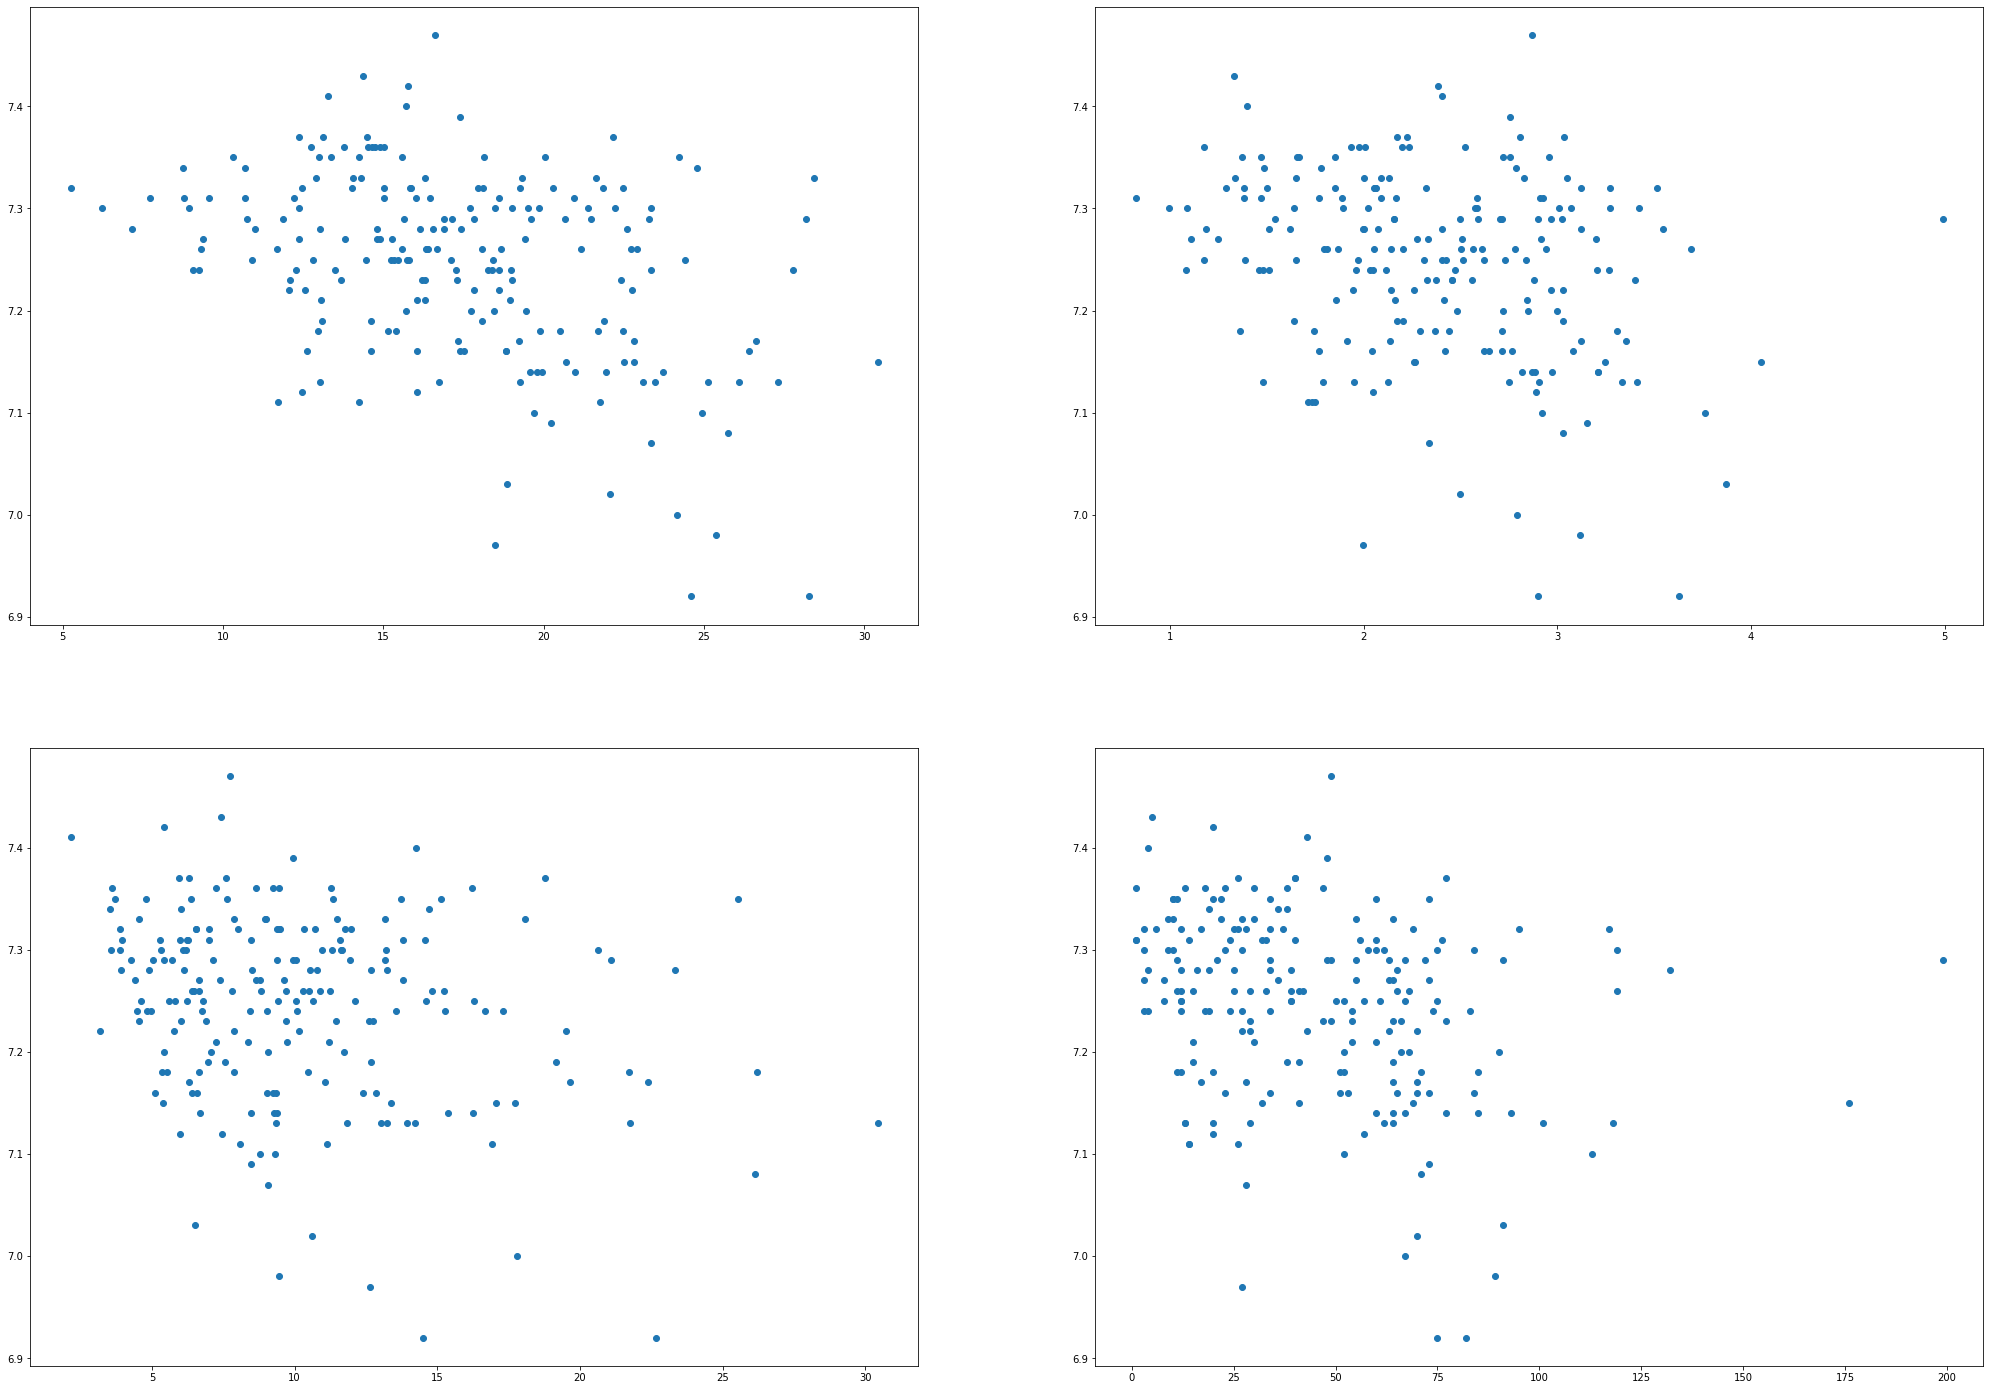

In [65]:
fig,ax = plt.subplots(2,2, figsize=(35,25))
ax[0][0].scatter([hrv_val['sdnn'][0] for _, hrv_val in df1h_fin['HRV_res'].iteritems()] , [hrv_val['pH'] for _, hrv_val in df1h_fin['labels'].iteritems()])
ax[0][1].scatter([hrv_val['rmssd'][0] for _, hrv_val in df1h_fin['HRV_res'].iteritems()] , [hrv_val['pH'] for _, hrv_val in df1h_fin['labels'].iteritems()])
ax[1][0].scatter([hrv_val['sdann'][0] for _, hrv_val in df1h_fin['HRV_res'].iteritems()] , [hrv_val['pH'] for _, hrv_val in df1h_fin['labels'].iteritems()])
ax[1][1].scatter([hrv_val['nn20'][0] for _, hrv_val in df1h_fin['HRV_res'].iteritems()] , [hrv_val['pH'] for _, hrv_val in df1h_fin['labels'].iteritems()])

In [79]:
from scipy.stats import pearsonr, spearmanr, kendalltau

def get_correlation(df, column_name):
    results = {'sdnn': [], 'rmssd': [], 'sdann': [], 'nn20': [], 'nn50': []}

    for method_name in results.keys():
        results[method_name].append( 
            pearsonr(
                [hrv_val[method_name][0] for _, hrv_val in df['HRV_res'].iteritems()] ,
                [hrv_val[column_name] for _, hrv_val in df['labels'].iteritems()]
            )[0]
        )
        results[method_name].append( 
            spearmanr(
                [hrv_val[method_name][0] for _, hrv_val in df['HRV_res'].iteritems()] ,
                [hrv_val[column_name] for _, hrv_val in df['labels'].iteritems()]
            )[0]
        )
        results[method_name].append( 
            kendalltau(
                [hrv_val[method_name][0] for _, hrv_val in df['HRV_res'].iteritems()] ,
                [hrv_val[column_name] for _, hrv_val in df['labels'].iteritems()]
            )[0]
        )
    return results

print('apgar1 >= 7\n', get_correlation(df1h_fin, 'pH')); print()
print('apgar1 < 7\n', get_correlation(df1u_fin, 'pH')); print()
print('apgar5 >= 7\n', get_correlation(df5h_fin, 'pH')); print()
print('apgar5 < 7\n', get_correlation(df5u_fin, 'pH')); print()


apgar1 >= 7
 {'sdnn': [-0.3953703316085621, -0.3582262814184455, -0.25066581136233856], 'rmssd': [-0.2735508802907624, -0.25772785919306246, -0.17561388306020412], 'sdann': [-0.2508622609178826, -0.20083435929606525, -0.1381356012015779], 'nn20': [-0.2752460448219036, -0.3023473177269474, -0.2095377362690176], 'nn50': [-0.17676150719636124, -0.2278808921400344, -0.16637813937815818]}

apgar1 < 7
 {'sdnn': [-0.23379695543070575, -0.12616816103319023, -0.08153326507837144], 'rmssd': [0.1525702445327728, 0.15158553328016788, 0.11065228832064694], 'sdann': [-0.20982889411586025, -0.07502718313866895, -0.04659043718764082], 'nn20': [0.013347783246985942, 0.13800027801321013, 0.09928795479301851], 'nn50': [-0.03526601449881675, -0.12470836055604055, -0.09731697114538015]}

apgar5 >= 7
 {'sdnn': [-0.3983298857060569, -0.3601612742578198, -0.2529682425473181], 'rmssd': [-0.2490442988328288, -0.22835418806166619, -0.15472814835418486], 'sdann': [-0.2663072295879088, -0.20631669785501547, -0.140

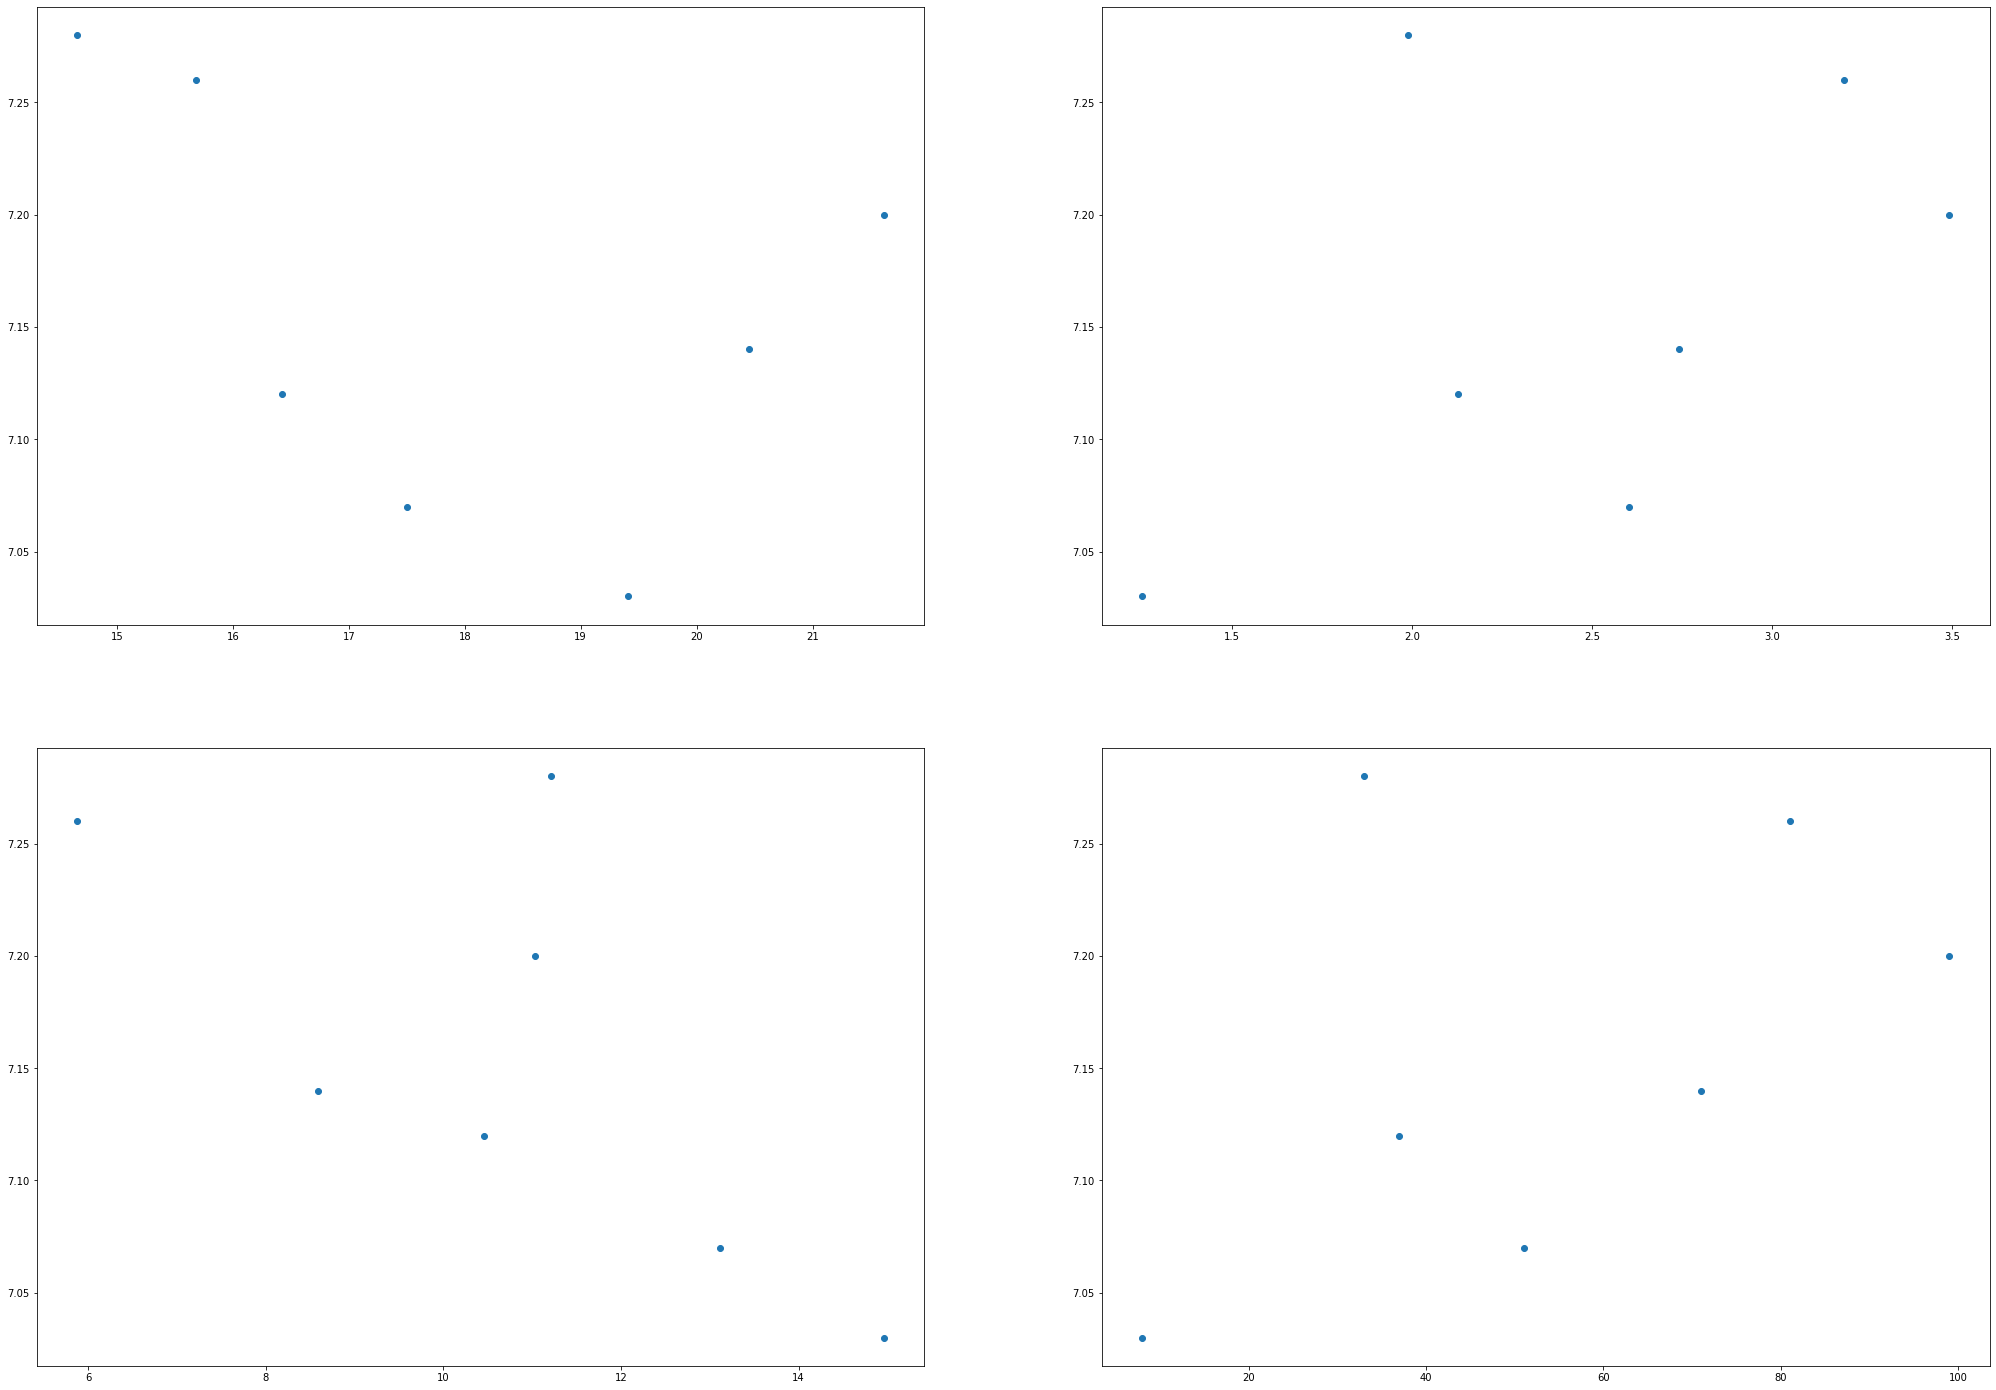

In [70]:
fig,ax = plt.subplots(2,2, figsize=(35,25))
ax[0][0].scatter([hrv_val['sdnn'][0] for _, hrv_val in df5u_fin['HRV_res'].iteritems()] , [hrv_val['pH'] for _, hrv_val in df5u_fin['labels'].iteritems()])
ax[0][1].scatter([hrv_val['rmssd'][0] for _, hrv_val in df5u_fin['HRV_res'].iteritems()] , [hrv_val['pH'] for _, hrv_val in df5u_fin['labels'].iteritems()])
ax[1][0].scatter([hrv_val['sdann'][0] for _, hrv_val in df5u_fin['HRV_res'].iteritems()] , [hrv_val['pH'] for _, hrv_val in df5u_fin['labels'].iteritems()])
ax[1][1].scatter([hrv_val['nn20'][0] for _, hrv_val in df5u_fin['HRV_res'].iteritems()] , [hrv_val['pH'] for _, hrv_val in df5u_fin['labels'].iteritems()])